In [143]:
import json
import requests
from rickpy import ProgressBar

In [154]:
def get_summary(cid):
    url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%d/description/json' % cid
    result = requests.get(url)
    summary = json.loads(result.content)
    return summary

def parse_summary_for_odor(summary):
    statements = []
    # keywords should include aroma but exclude aromatic (due to its special meaning in chemistry)
    keywords = ('odor', 'odour', 'smell', 'aroma ', 'aroma,', 'aroma.', 'fragrance')
    if 'InformationList' in summary:
        for item in summary['InformationList']['Information']:
            if 'Description' in item:
                for statement in item['Description'].split('.'):
                    if any([x in statement.lower() for x in keywords]):
                        statements.append(statement.strip())
    return statements

In [155]:
start = cid
finish = int(1e5)
p = ProgressBar(finish-start)
for cid in range(start, finish):
    p.animate(cid-start)
    try:
        summary = get_summary(cid)
    except requests.exceptions.SSLError:
        print("SSLError for CID %d" % cid)
    else:
        statements = parse_summary_for_odor(summary)
        if statements:
            #print(cid, statements)
            summ_statements[cid] = statements

[-----------------------99%----------------------] 74071 out of 74072 complete

In [159]:
def get_physical_description(cid):
    url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/%d/JSON?heading=Physical+Description' % cid
    result = requests.get(url)
    try:
        summary = json.loads(result.content)
    except UnicodeDecodeError:
        summary = {}
    return summary

def parse_physical_description_for_odor(physical_description):
    statements = []
    try:
        strings = [x['Value']['StringWithMarkup'][0]['String']
                   for x in physical_description['Record']['Section'][0]['Section'][0]['Section'][0]['Information']]
    except KeyError:
        pass
    else:
        # keywords should include aroma but exclude aromatic (due to its special meaning in chemistry)
        keywords = ('odor', 'odour', 'smell', 'aroma ', 'aroma,', 'aroma.', 'fragrance')
        for string in strings:
            for statement in string.split('.'):
                if any([x in statement.lower() for x in keywords]):
                    statements.append(statement.strip())
    return statements

In [160]:
start = cid
finish = int(1e5)
p = ProgressBar(finish-start)
for cid in range(start, finish):
    p.animate(cid-start)
    try:
        phys = get_physical_description(cid)
    except requests.exceptions.SSLError:
        print("SSLError for CID %d" % cid)
    else:
        statements = parse_physical_description_for_odor(phys)
        if statements:
            #print(cid, statements)
            phys_statements[cid] = statements

[-----------------------99%----------------------] 84061 out of 84062 complete

In [161]:
summ_cids = set(key for key in summ_statements)
phys_cids = set(key for key in phys_statements)
len(summ_cids), len(phys_cids), len(summ_cids.difference(phys_cids)), len(phys_cids.difference(summ_cids))

(1170, 1758, 174, 762)

In [162]:
all_statements = {}
for cid in set(summ_statements) | set(phys_statements):
    summ_statements_cid = summ_statements.get(cid, [])
    phys_statements_cid = phys_statements.get(cid, [])
    all_statements[cid] = summ_statements_cid + phys_statements_cid

In [171]:
import re
from IPython.display import HTML, display

def color(cid, s, code):
    return "<p style='color: %s'>%d: %s</p>" % (code, cid, s)

html = ""
for cid in sorted(all_statements):
    statements = all_statements[cid]
    odor = 0
    odorless = 0
    for statement in statements:
        statement = statement.lower()
        if re.findall('no odor', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('no odour', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('no smell', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('no fragrance', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('odorless', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('odourless', statement):
            html += color(cid, statement, '#00BB00')
        elif re.findall('odoratus', statement):
            html += color(cid, statement, '#000000')
        elif re.findall('sense of smell', statement):
            html += color(cid, statement, '#DD0000')
        elif re.findall('odor', statement):
            html += color(cid, statement, '#DD0000')
        elif re.findall('odour', statement):
            html += color(cid, statement, '#DD0000')
        elif re.findall('smell', statement):
            html += color(cid, statement, '#DD0000')
        elif re.findall('fragrance', statement):
            html += color(cid, statement, '#DD0000')
        elif re.findall('aroma ', statement):
            html += color(cid, statement, '#DD0000')
        else:
            html += color(cid, statement, '#000000')
    #if odor and odorless:
    #    print(statements)
    
#display(HTML(html))
with open('../data/pubchem_scrape_100000.html', 'w') as f:
    f.write(html)

In [170]:
import pickle
with open('../data/pubchem_scrape_100000.pkl', 'wb') as f:
    pickle.dump(all_statements, f)

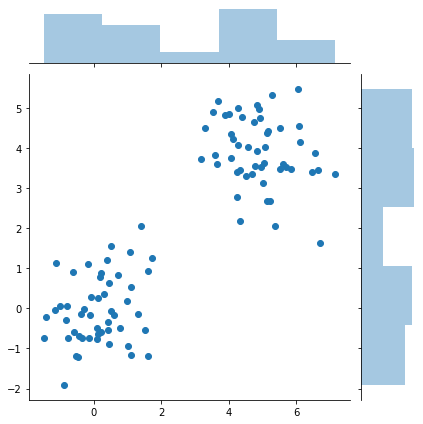

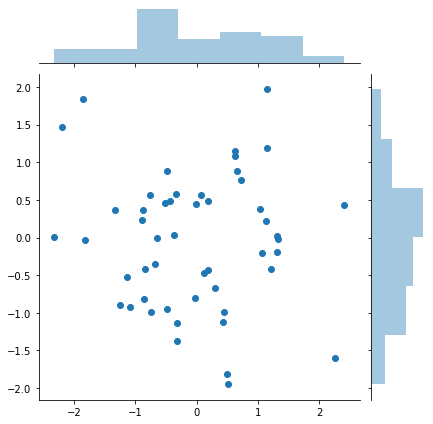

In [196]:
import numpy as np
import seaborn as sns
x = list(np.random.randn(50, 2)) + list(np.array([5,4])+np.random.randn(50, 2))
y = list(np.random.randn(50, 2))
sns.jointplot(*np.array(x).T)
sns.jointplot(*np.array(y).T)

In [177]:
np.random.randn(1)

array([0.09190899])

In [180]:
np.random.randn(20)

array([-0.44803909, -0.29980779, -0.8957368 ,  0.72161359,  0.11313407,
       -0.58889416,  0.66920256,  0.35192821,  0.92298029, -3.64768366,
        0.59565269, -0.62126484,  0.20733118,  0.14767707, -0.25080624,
       -0.55627507,  1.56742938, -0.05658108,  1.30866078, -0.8848005 ])